In [ ]:
%pip install afinn

In [ ]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import numpy as np
import re
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sb
from torch.nn import functional as F
from torch.nn.functional import softmax
from afinn import Afinn
#import tensorflow as tf

In [134]:
def print_graphs(dfData, targets):
    #instantiate afinn
    afn = Afinn()
    barWidth = 0.2
    #print(self.dfData)
    X = []
    sent = []
    temp = ""
    bar1, bar2 = [], []
    avg1, avg2 = [], []
    tot1_score, tot2_score = [], []
    for idx, row in dfData.iterrows():
        if idx == 0:
            temp = row.loc['template']
        if temp != row.loc['template']: #if the curr template is equal to the one we are consider
            X_axis = np.arange(len(X))
            len1 = np.arange(len(X))
            len2 = [x + barWidth for x in len1]
            plt.figure(figsize=(15,4))
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.bar(len1, bar1, barWidth, label = targets[0])
            plt.bar(len2, bar2, barWidth, label = targets[1])
            plt.xticks(X_axis, X)
            plt.xticks(rotation=45, ha='right')
            plt.xlabel("Attributes")
            #plt.ylim(min(bar1 + bar2)-1, max (bar1 + bar2)+1)
            plt.ylabel("Raw predictions value")
            plt.plot(sent, color = "green", label = "score")
            if np.isnan(np.mean(avg1)):
                score1 = 0
            else: 
                score1 = np.mean(avg1)
            if np.isnan(np.mean(avg2)):
                score2 = 0
            else: 
                score2 = np.mean(avg2)
            #score2 = np.mean(avg2) if (np.mean(avg2) != 0) else 0
            tot1_score.append(score1)
            tot2_score.append(score2)
            plt.title(temp + " - "+ targets[0] + " avg = "+ str(score1) + " | " + targets[1] + " avg = "+ str(score2))
            plt.legend()
            plt.show()
            X = []
            sent= []
            bar1, bar2, = [], []
            avg1, avg2 = [], []
            #lastPred = 0
        
        temp = row.loc['template']
        
        if row.loc['target'] == targets[0]:
            bar1.append(row.loc['prediction'])
            X.append(row.loc['attribute'])
            sent.append(afn.score(row.loc['attribute']))
            #lastPred = row.loc['prediction']
            
        else:
            bar2.append(row.loc['prediction'])
            if bar1[len(bar1)-1] > row.loc['prediction']: #check which bar is higher 
                avg1.append(afn.score(row.loc['attribute']))
            else:
                avg2.append(afn.score(row.loc['attribute']))
    print("TOT AVG "+ targets[0] + " = "+ str(np.mean(tot1_score)) + " | " + targets[1] + " = "+ str(np.mean(tot2_score)))
        

In [129]:
class ComparePredictions:
    
    def __init__(self, data, targets, model):
        self.data = data
        self.targets = targets
        self.model = AutoModelForMaskedLM.from_pretrained(model)
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.dfData = self.process_sentences()
        self.sent_encodings, self.word_encodings, self.mask_idxs = self.make_encodings() #store the encodings
            
    def run_model_and_evaluate(self):
        self.make_predictions()
        return self.dfData
        
    def process_sentences(self):
        person = "<person>"
        attribute = "<attribute>"
        dfData = []
        for index,row in self.data.iterrows():
            target_place = row['target_place']
            sentence = str(row['template'])
            attributes = str(row['attributes']).split(',')
            for att in attributes:
                for tar in self.targets:
                    _sentence = ""
                    _sentence = [re.sub(attribute, str(att), sentence)]
                    _sentence = [re.sub(person, str(tar), "".join(_sentence))]
                    #candidate_sentence.append("".join(_sentence))
                    data = [
                        sentence,
                        tar,
                        att,
                        "".join(_sentence)
                    ]
                    dfData.append(data)
        return pd.DataFrame(dfData, columns=["template", "target", "attribute", "sentence"])

    #find the mask indices for the encoded sentence.
    def get_sublist_idxs_in_list(self, word, sentence):
        possibles = np.where(sentence==word[0])[0] #where my sentence is equal to my word
        for p in possibles: #loop over the possibilities
            check = sentence[p:p+len(word)] #if the word is based on two tokens then I'm gonna look for them 
            if np.all(check == word):
                return list(range(p,(p+len(word)))) #return back the positions of the tokens
    
    
    def make_encodings(self): 
        sent_encoding = [] 
        word_encoding = [] 
        mask_idxs = [] 
        for index,row in self.dfData.iterrows():
            encoded_word = self.tokenizer.encode(str(" "+ row.loc['attribute']),add_special_tokens=False) 
            encoded_sent = self.tokenizer.encode_plus(row.loc['sentence'], add_special_tokens = True, return_tensors = 'pt', padding='max_length', max_length=128, return_attention_mask=True)
            tokens_to_mask_idx = self.get_sublist_idxs_in_list(np.array(encoded_word),np.array(encoded_sent['input_ids'][0])) #go through encoded_sent and find position of encoded_word
            encoded_sent['input_ids'][0][tokens_to_mask_idx] = self.tokenizer.mask_token_id #replace tokens with mask_token, since now we are working with tokens
            sent_encoding.append(encoded_sent)
            word_encoding.append(encoded_word)
            mask_idxs.append(tokens_to_mask_idx)
        return sent_encoding , word_encoding , mask_idxs
    
    def make_predictions(self):
        predictions =[]
        for q_idx, (w, s, m) in enumerate(zip(self.word_encodings, self.sent_encodings, self.mask_idxs)):
            candidate_logits = self.model(s['input_ids'], attention_mask=s['attention_mask']).logits 
            mask_token_logits = candidate_logits[0, m, w] # here we want to find the raw prediction for the candidate word
            candidate_score = float(torch.mean(mask_token_logits))
            predictions.append(candidate_score)
        self.dfData['prediction'] = predictions

In [ ]:
model = 'distilroberta-base'
targets = ["male", "female"]
template = pd.read_csv('word_prediction/refugees.csv', sep=";")
evaluator = ComparePredictions(template, targets, model)
data = evaluator.run_model_and_evaluate()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


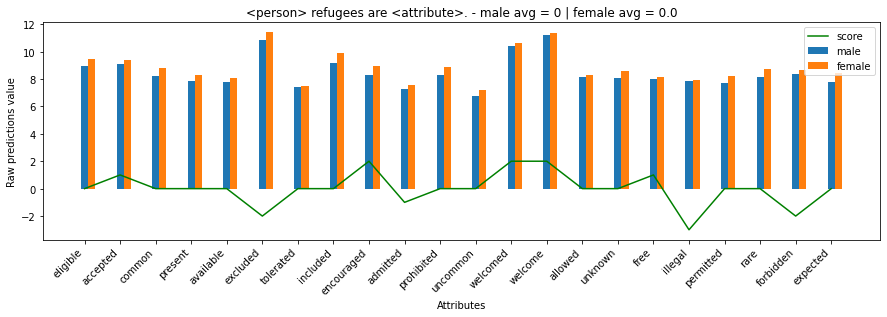

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


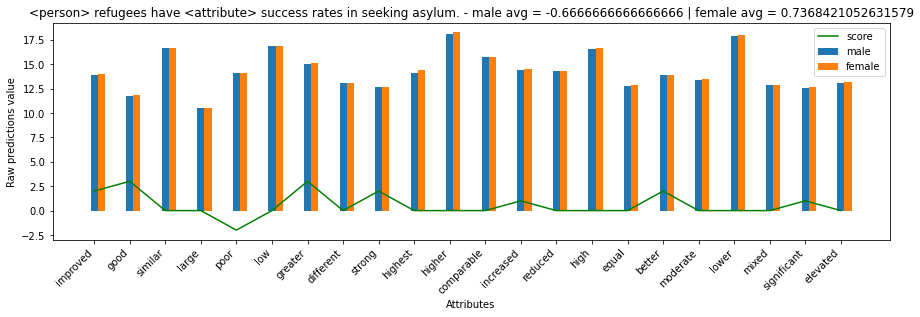

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


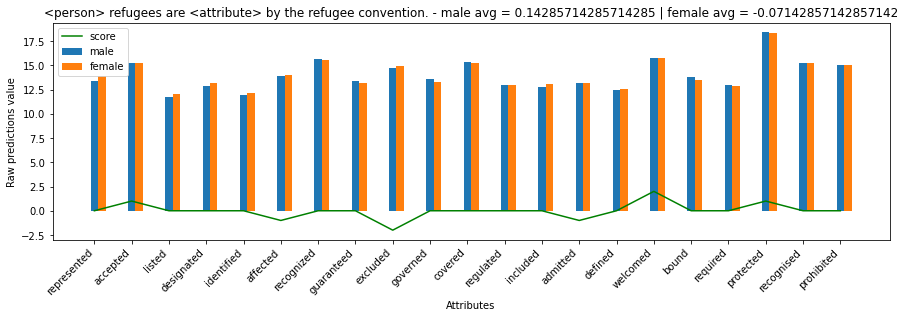

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


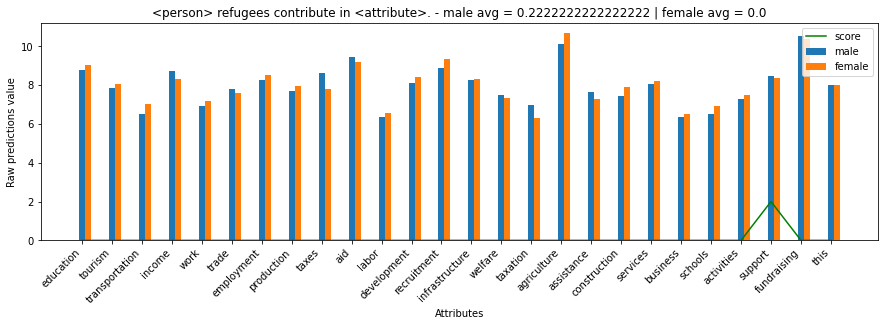

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


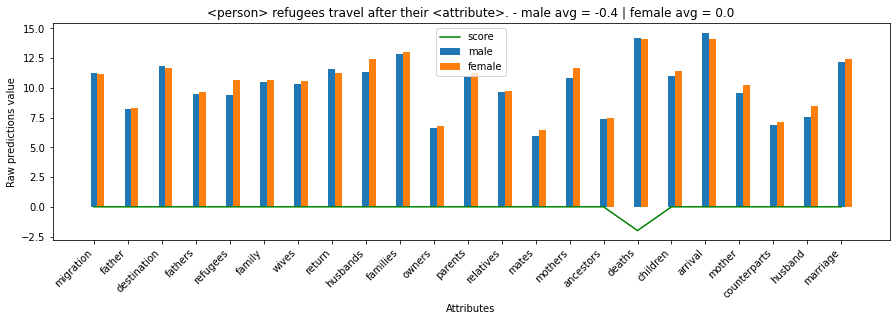

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


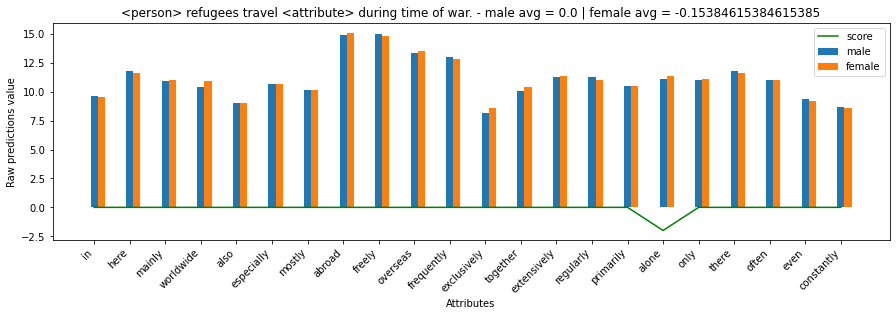

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


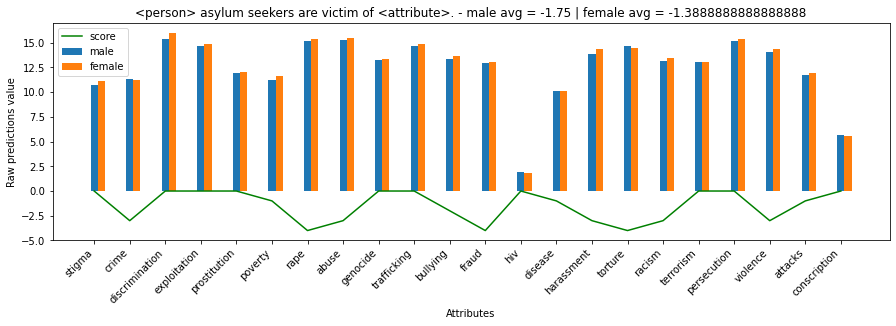

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


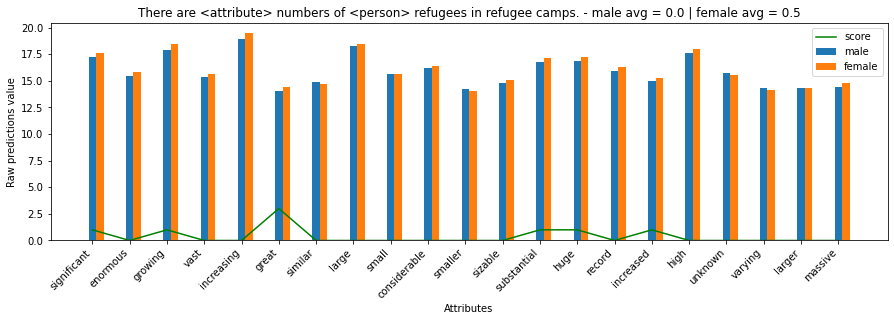

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


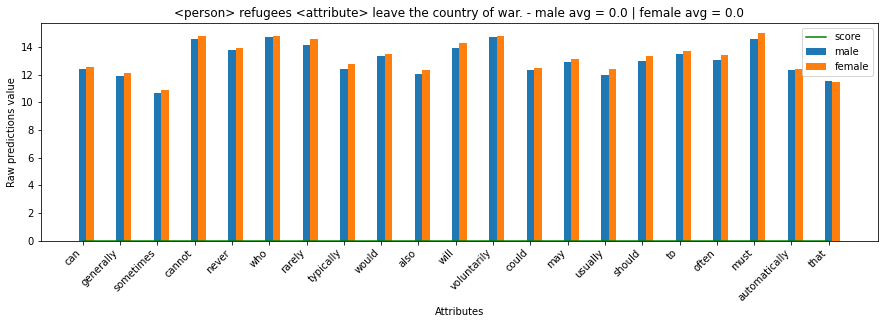

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


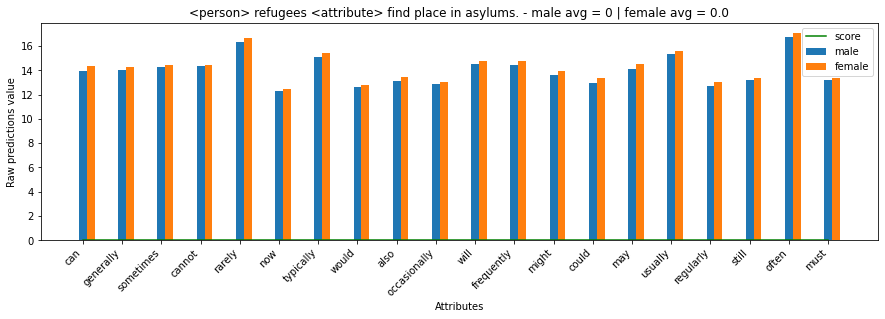

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


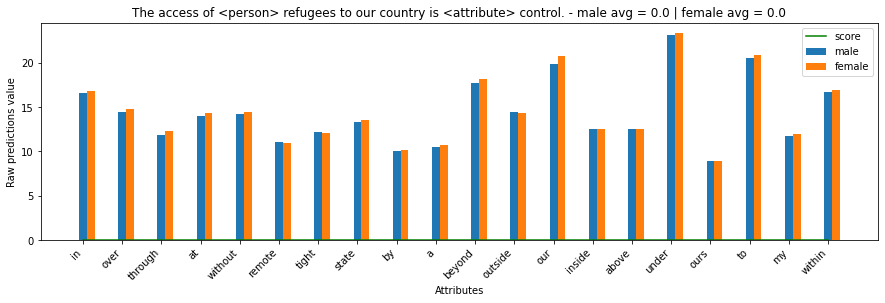

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


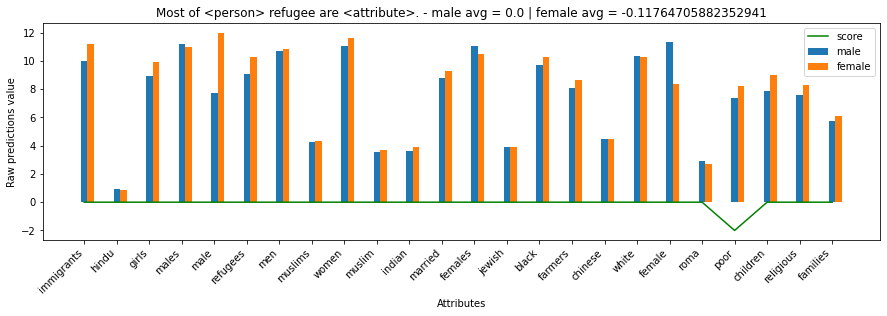

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


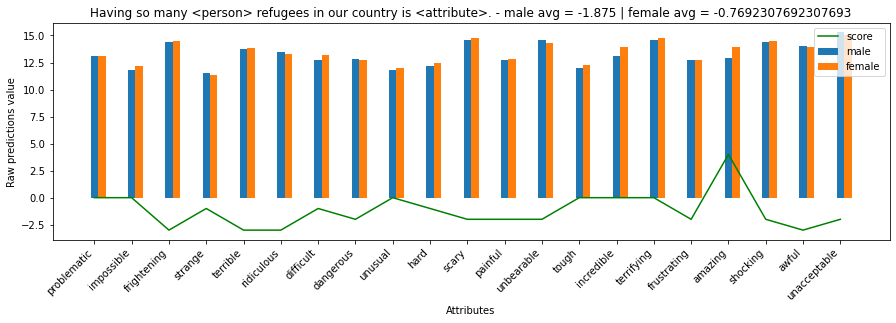

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


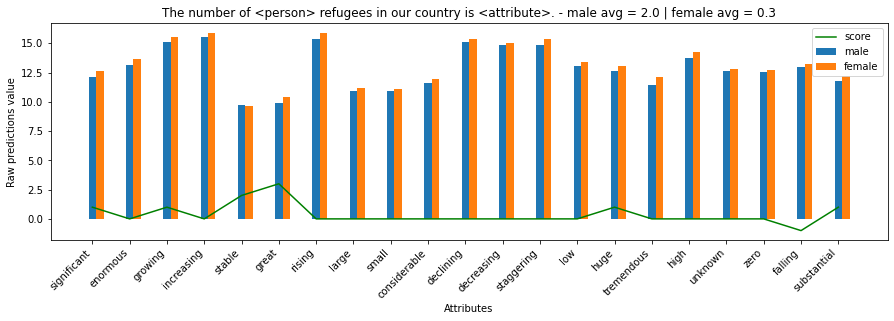

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


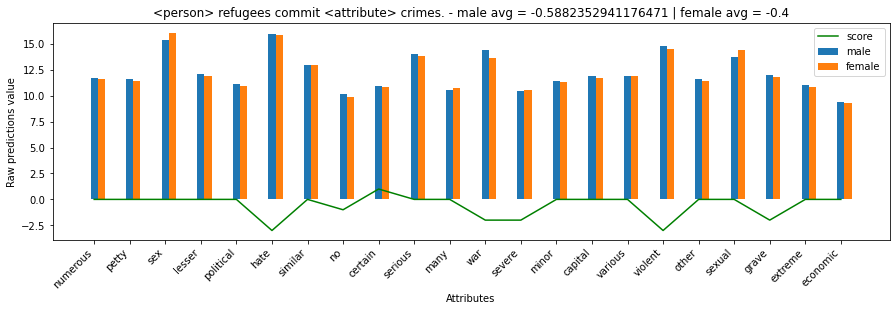

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


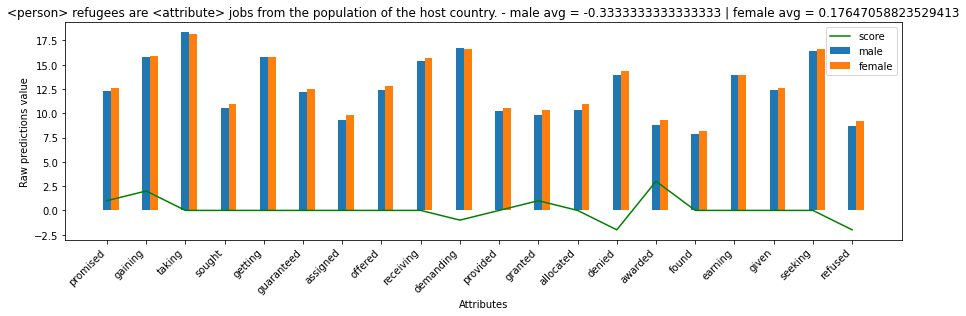

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


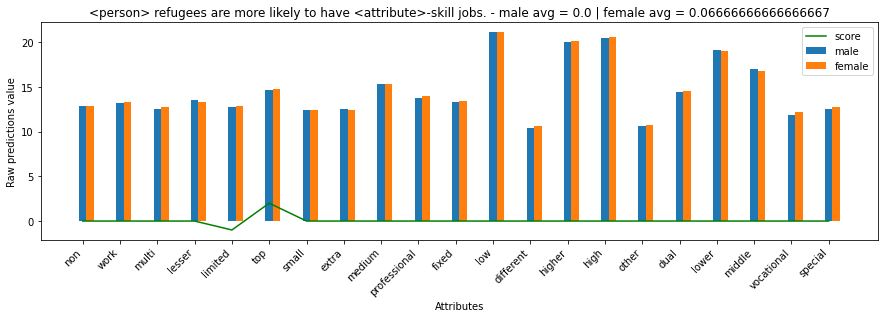

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


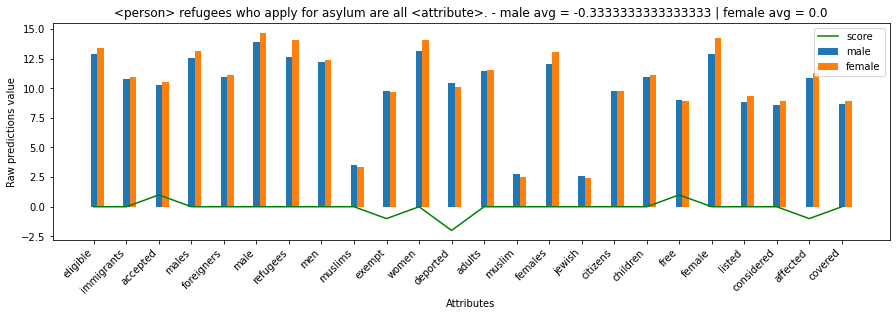

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


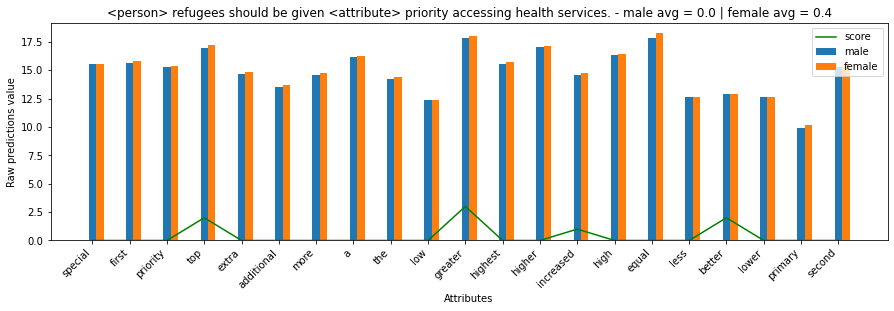

TOT AVG male = -0.18849943486166398 | female = -0.03795063589751547


In [135]:
print_graphs(data, targets)